In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from ema_pytorch import EMA
from accelerate import Accelerator
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from scipy.ndimage import zoom
import random

import sys
sys.path.append("../../")
import pandas as pd
import os
import numpy as np
from tqdm.auto import tqdm
import nibabel as nb
import matplotlib.pyplot as plt
import DeepStrain.functions_collection as ff
import DeepStrain.Data_processing as dp


# write a data generator

In [56]:
spreadsheet_path = '/mnt/camca_NAS/HFpEF/data/HFpEF_data/Patient_list/Important_HFpEF_Patient_list_unique_patient_w_readmission_finalized.xlsx' 
patient_list = pd.read_excel(spreadsheet_path)[0:50]
dl_seg_path = '/mnt/camca_NAS/SAM_for_CMR/models/sam_multiview_prompt_2box_text_HF_5shot/predicts_HFpEF'

index_list = []
for i in range(0, len(patient_list)):
    patient_id = patient_list['OurID'][i]; patient_id = ff.XX_to_ID_00XX(patient_id)
    if os.path.isdir(os.path.join(dl_seg_path, patient_id)):
        index_list.append(i)
patient_list = patient_list.iloc[index_list]

In [52]:
for i in range(2, len(patient_list)):
    patient_id = patient_list['OurID'].iloc[i]; patient_id = ff.XX_to_ID_00XX(patient_id)
    # load data
    print(patient_id)
    pred_seg_files = ff.sort_timeframe(ff.find_all_target_files(['pred_seg*'], os.path.join(dl_seg_path, patient_id, 'epoch-81')),2,'_','.')
    print(pred_seg_files)

    # load one for dimension
    a = nb.load(pred_seg_files[0]).get_fdata()

    # load 4D
    pred_seg = np.zeros([len(pred_seg_files), a.shape[0], a.shape[1], a.shape[2]])
    for j in range(0, len(pred_seg_files)):
        pred_seg[j] = nb.load(pred_seg_files[j]).get_fdata()
    pred_seg = np.transpose(pred_seg, (3,1,2,0))

    # pad slice
    pred_seg_pad = np.zeros([a.shape[-1], a.shape[0], a.shape[1], 15])
    if pred_seg.shape[-1] < 15:
        pad = 15 - pred_seg.shape[-1]
        pad_before = pad//2
        pad_after = pad - pad_before
        for k in range(0, pred_seg.shape[0]):
            a = pred_seg[k,...]
            pred_seg_pad[k] = np.pad(a, ((0,0),(0,0),(pad_before,pad_after)))
  
    # pad x y
    pred_seg_final = np.zeros([15, 128,128, 15])
    for j in range(0, pred_seg_pad.shape[0]):
        pred_seg_final[j,...],_,_ = dp.center_crop(pred_seg_pad[j,...], pred_seg_pad[j,...], [128,128,15], according_to_which_class=[1])
    
    # downsample x and y by 2
    pred_seg_ds = np.zeros([15, 64,64, 15])
    for j in range(0, pred_seg_final.shape[0]):
        pred_seg_ds[j,...] = zoom(pred_seg_final[j,...], (0.5,0.5,1), order=0)
    print(pred_seg_ds.shape)
    break

    

ID_0085
['/mnt/camca_NAS/SAM_for_CMR/models/sam_multiview_prompt_2box_text_HF_5shot/predicts_HFpEF/ID_0085/epoch-81/pred_seg_0.nii.gz'
 '/mnt/camca_NAS/SAM_for_CMR/models/sam_multiview_prompt_2box_text_HF_5shot/predicts_HFpEF/ID_0085/epoch-81/pred_seg_1.nii.gz'
 '/mnt/camca_NAS/SAM_for_CMR/models/sam_multiview_prompt_2box_text_HF_5shot/predicts_HFpEF/ID_0085/epoch-81/pred_seg_2.nii.gz'
 '/mnt/camca_NAS/SAM_for_CMR/models/sam_multiview_prompt_2box_text_HF_5shot/predicts_HFpEF/ID_0085/epoch-81/pred_seg_3.nii.gz'
 '/mnt/camca_NAS/SAM_for_CMR/models/sam_multiview_prompt_2box_text_HF_5shot/predicts_HFpEF/ID_0085/epoch-81/pred_seg_4.nii.gz'
 '/mnt/camca_NAS/SAM_for_CMR/models/sam_multiview_prompt_2box_text_HF_5shot/predicts_HFpEF/ID_0085/epoch-81/pred_seg_5.nii.gz'
 '/mnt/camca_NAS/SAM_for_CMR/models/sam_multiview_prompt_2box_text_HF_5shot/predicts_HFpEF/ID_0085/epoch-81/pred_seg_6.nii.gz'
 '/mnt/camca_NAS/SAM_for_CMR/models/sam_multiview_prompt_2box_text_HF_5shot/predicts_HFpEF/ID_0085/epoc

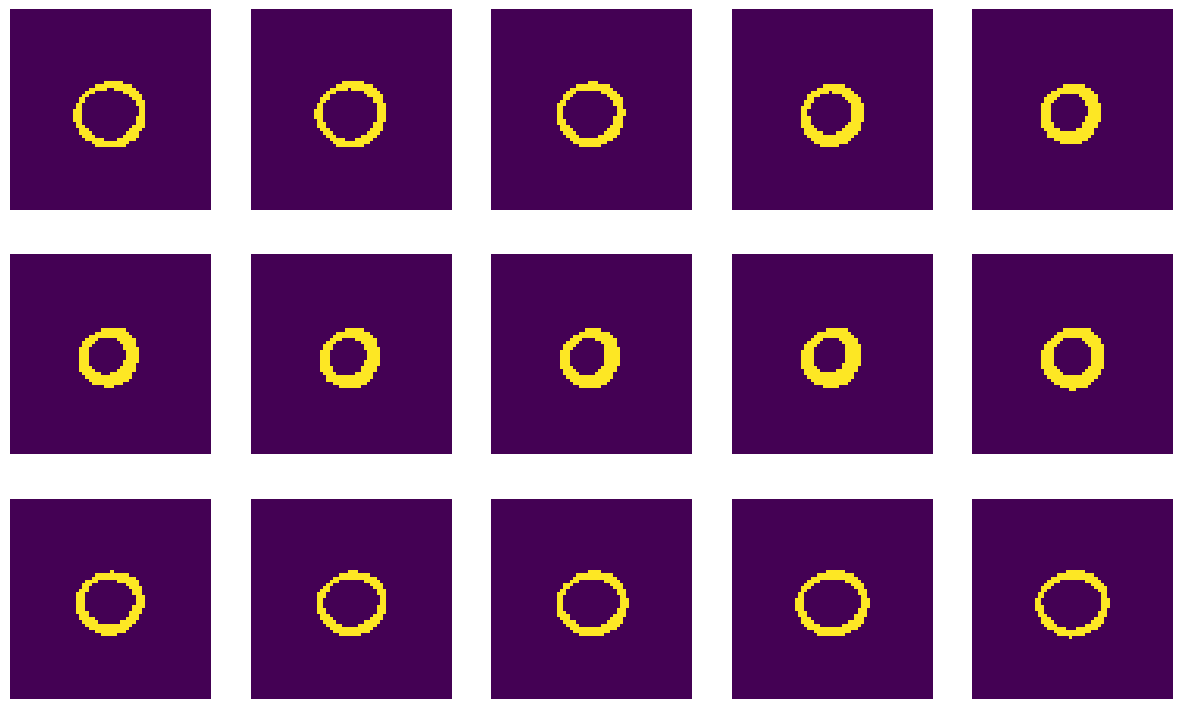

In [54]:
# plot seg_ed and seg_es
fig, ax = plt.subplots(3,5, figsize = (15,9))
for i in range(15):
    ax[i//5, i%5].imshow(pred_seg_ds[i,:,:,3])
    ax[i//5, i%5].axis('off')

In [3]:
class Dataset_seg_EDES(Dataset):

    def __init__(
        self,
        patient_list,
        manual_seg_path,
        shuffle = False,
        augment = False,
        augment_frequency = 0,
    ):
        super().__init__()
        
        self.patient_list = patient_list
        self.manual_seg_path = manual_seg_path
        self.shuffle = shuffle
        self.augment = augment
        self.augment_frequency = augment_frequency
        self.num_files = patient_list.shape[0]

        self.index_array = self.generate_index_array()
       
    def generate_index_array(self):
        np.random.seed()
        index_array = []
        
        if self.shuffle == True:
            index_array = np.random.permutation(self.num_files)
        else:
            index_array = np.arange(self.num_files)
        return index_array

    def __len__(self):
        return self.num_files 
    
    def load_seg(self, patient_id):
        seg_file_ed = os.path.join(self.manual_seg_path, patient_id, 'SAX_ED_seg.nii.gz')
        seg_file_es = os.path.join(self.manual_seg_path, patient_id, 'SAX_ES_seg.nii.gz')

        seg_ed = nb.load(seg_file_ed).get_fdata(); seg_ed = np.round(seg_ed).astype(int); seg_ed[seg_ed == 1] = 0; seg_ed[seg_ed > 1] = 1
        seg_es = nb.load(seg_file_es).get_fdata(); seg_es = np.round(seg_es).astype(int); seg_es[seg_es == 1] = 0; seg_es[seg_es > 1] = 1

        # find the slices with content in seg_ed
        slice_idx = np.where(np.sum(seg_ed, axis = (0,1))>0)[0]

        # only keep these slices
        seg_ed = seg_ed[:,:,slice_idx]
        seg_es = seg_es[:,:,slice_idx]

        # make slice number = 15 by padding zero slices and make sure the non-zero slices are in the middle
        if slice_idx.shape[0] < 15:
            pad = 15 - slice_idx.shape[0]
            pad_before = pad//2
            pad_after = pad - pad_before
            seg_ed = np.pad(seg_ed, ((0,0),(0,0),(pad_before,pad_after)))
            seg_es = np.pad(seg_es, ((0,0),(0,0),(pad_before,pad_after)))
        elif slice_idx.shape[0] > 15:
            ValueError('the number of slices in seg_ed is larger than 15')
        
        seg_ed,_,_ = dp.center_crop(seg_ed, seg_ed, [128,128,15],according_to_which_class=[1])
        seg_es,_,_ = dp.center_crop(seg_es, seg_es, [128,128,15],according_to_which_class=[1])
        
        # stack the seg_ed and seg_es
        seg_ed = np.expand_dims(seg_ed, axis = -1)
        seg_es = np.expand_dims(seg_es, axis = -1)
        seg = np.concatenate((seg_ed, seg_es), axis = -1)

        return seg
        
    def __getitem__(self, index):
        # print('in this geiitem, self.index_array is: ', self.index_array)
        f = self.index_array[index]
        row = self.patient_list.iloc[f]
        patient_id = row['OurID']; patient_id = ff.XX_to_ID_00XX(patient_id)
        # print('index is: ', index, ' now we pick patient: ', patient_id)
        
        # load the x data
        x = self.load_seg(patient_id)
        if self.augment == True:
            if random.uniform(0,1) < self.augment_frequency:
                x_ed, z_rotate_degree = dp.random_rotate(x[:,:,:,0], z_rotate_range = [-10,10], order = 0)
                x_ed, x_translate, y_translate  = dp.random_translate(x_ed, translate_range=[-10,10])
                x_es, z_rotate_degree = dp.random_rotate(x[:,:,:,1], z_rotate_degree= z_rotate_degree, order = 0)
                x_es, x_translate, y_translate  = dp.random_translate(x_es, x_translate = x_translate, y_translate = y_translate)
                x = np.stack((x_ed, x_es), axis = -1)
        x = np.transpose(x, (3,0,1,2))
            
        # load the y value
        y = np.array([row['label_for_ML']])

        x = torch.from_numpy(x).float()
        y = torch.from_numpy(y).float()

        return x, y
    
    def on_epoch_end(self):
        print('now run on_epoch_end function')
        self.index_array = self.generate_index_array()
        

In [80]:
class Dataset_seg_full(Dataset):

    def __init__(
        self,
        patient_list,
        dl_seg_path,
        shuffle = False,
        augment = False,
        augment_frequency = 0,
    ):
        super().__init__()
        
        self.patient_list = patient_list
        self.dl_seg_path = dl_seg_path
        self.shuffle = shuffle
        self.augment = augment
        self.augment_frequency = augment_frequency
        self.num_files = patient_list.shape[0]

        self.index_array = self.generate_index_array()
       
    def generate_index_array(self):
        np.random.seed()
        index_array = []
        
        if self.shuffle == True:
            index_array = np.random.permutation(self.num_files)
        else:
            index_array = np.arange(self.num_files)
        return index_array

    def __len__(self):
        return self.num_files 
    
    def load_seg(self, patient_id):
        # load data
        pred_seg_files = ff.sort_timeframe(ff.find_all_target_files(['pred_seg*'], os.path.join(self.dl_seg_path, patient_id, 'epoch-81')),2,'_','.')
        # load one for dimension
        # print('pred_seg_files: ', pred_seg_files)
        a = nb.load(pred_seg_files[0]).get_fdata()

        # load 4D
        pred_seg = np.zeros([len(pred_seg_files), a.shape[0], a.shape[1], a.shape[2]])
        for j in range(0, len(pred_seg_files)):
            pred_seg[j] = nb.load(pred_seg_files[j]).get_fdata()
        pred_seg = np.transpose(pred_seg, (3,1,2,0))

        # pad slice
        pred_seg_pad = np.zeros([a.shape[-1], a.shape[0], a.shape[1], 15])
        if pred_seg.shape[-1] < 15:
            pad = 15 - pred_seg.shape[-1]
            pad_before = pad//2
            pad_after = pad - pad_before
            for k in range(0, pred_seg.shape[0]):
                a = pred_seg[k,...]
                pred_seg_pad[k] = np.pad(a, ((0,0),(0,0),(pad_before,pad_after)))
    
        # pad x y
        pred_seg_final = np.zeros([15, 128,128, 15])
        for j in range(0, pred_seg_pad.shape[0]):
            pred_seg_final[j,...],_,_ = dp.center_crop(pred_seg_pad[j,...], pred_seg_pad[j,...], [128,128,15], according_to_which_class=[1])
        
        # downsample x and y by 2
        # pred_seg_ds = np.zeros([15, 64,64, 15])
        # for j in range(0, pred_seg_final.shape[0]):
        #     pred_seg_ds[j,...] = zoom(pred_seg_final[j,...], (0.5,0.5,1), order=0)

        return pred_seg_final
        
    def __getitem__(self, index):
        # print('in this geiitem, self.index_array is: ', self.index_array)
        f = self.index_array[index]
        row = self.patient_list.iloc[f]
        patient_id = row['OurID']; patient_id = ff.XX_to_ID_00XX(patient_id)
        # print('index is: ', index, ' now we pick patient: ', patient_id)
        
        # load the x data
        x = self.load_seg(patient_id)
        if self.augment == True:
            if random.uniform(0,1) < self.augment_frequency:
                for volume_n in range(0, x.shape[0]):
                    if volume_n == 0:
                        x[volume_n,...], z_rotate_degree = dp.random_rotate(x[volume_n,...], z_rotate_range = [-10,10], order = 0)
                        x[volume_n,...], x_translate, y_translate  = dp.random_translate(x[volume_n,...], translate_range=[-10,10])
                    else:
                        x[volume_n,...], z_rotate_degree = dp.random_rotate(x[volume_n,...], z_rotate_degree= z_rotate_degree, order = 0)
                        x[volume_n,...], x_translate, y_translate  = dp.random_translate(x[volume_n,...], x_translate = x_translate, y_translate = y_translate)
        # print('after augmentation, x shape is: ', x.shape)
        # load the y value
        y = np.array([row['label_for_ML']])

        x = torch.from_numpy(x).float()
        y = torch.from_numpy(y).float()
        # print('finally, x shape and y shape are: ', x.shape, y.shape, ' y value is : ', y)

        return x, y
    
    def on_epoch_end(self):
        print('now run on_epoch_end function')
        self.index_array = self.generate_index_array()
        

In [68]:
dataset_trn = Dataset_seg_full(patient_list, dl_seg_path, shuffle = True, augment = True, augment_frequency = 0.5)
a = DataLoader(dataset_trn, batch_size = 1, shuffle = True)


In [69]:
def cycle(dl):
    while True:
        for data in dl:
            yield data
            
cycle_dl = cycle(a)

count = 0
for batch in cycle_dl:
    data = batch
    count += 1

    if count == 2:
        break

index is:  3  now we pick patient:  ID_1354
pred_seg_files:  ['/mnt/camca_NAS/SAM_for_CMR/models/sam_multiview_prompt_2box_text_HF_5shot/predicts_HFpEF/ID_1354/epoch-81/pred_seg_0.nii.gz'
 '/mnt/camca_NAS/SAM_for_CMR/models/sam_multiview_prompt_2box_text_HF_5shot/predicts_HFpEF/ID_1354/epoch-81/pred_seg_1.nii.gz'
 '/mnt/camca_NAS/SAM_for_CMR/models/sam_multiview_prompt_2box_text_HF_5shot/predicts_HFpEF/ID_1354/epoch-81/pred_seg_2.nii.gz'
 '/mnt/camca_NAS/SAM_for_CMR/models/sam_multiview_prompt_2box_text_HF_5shot/predicts_HFpEF/ID_1354/epoch-81/pred_seg_3.nii.gz'
 '/mnt/camca_NAS/SAM_for_CMR/models/sam_multiview_prompt_2box_text_HF_5shot/predicts_HFpEF/ID_1354/epoch-81/pred_seg_4.nii.gz'
 '/mnt/camca_NAS/SAM_for_CMR/models/sam_multiview_prompt_2box_text_HF_5shot/predicts_HFpEF/ID_1354/epoch-81/pred_seg_5.nii.gz'
 '/mnt/camca_NAS/SAM_for_CMR/models/sam_multiview_prompt_2box_text_HF_5shot/predicts_HFpEF/ID_1354/epoch-81/pred_seg_6.nii.gz']
finally, x shape and y shape are:  torch.Size([15

In [71]:
pred_seg_ds = data[0][0].numpy()
print(pred_seg_ds.shape)

(15, 128, 128, 15)


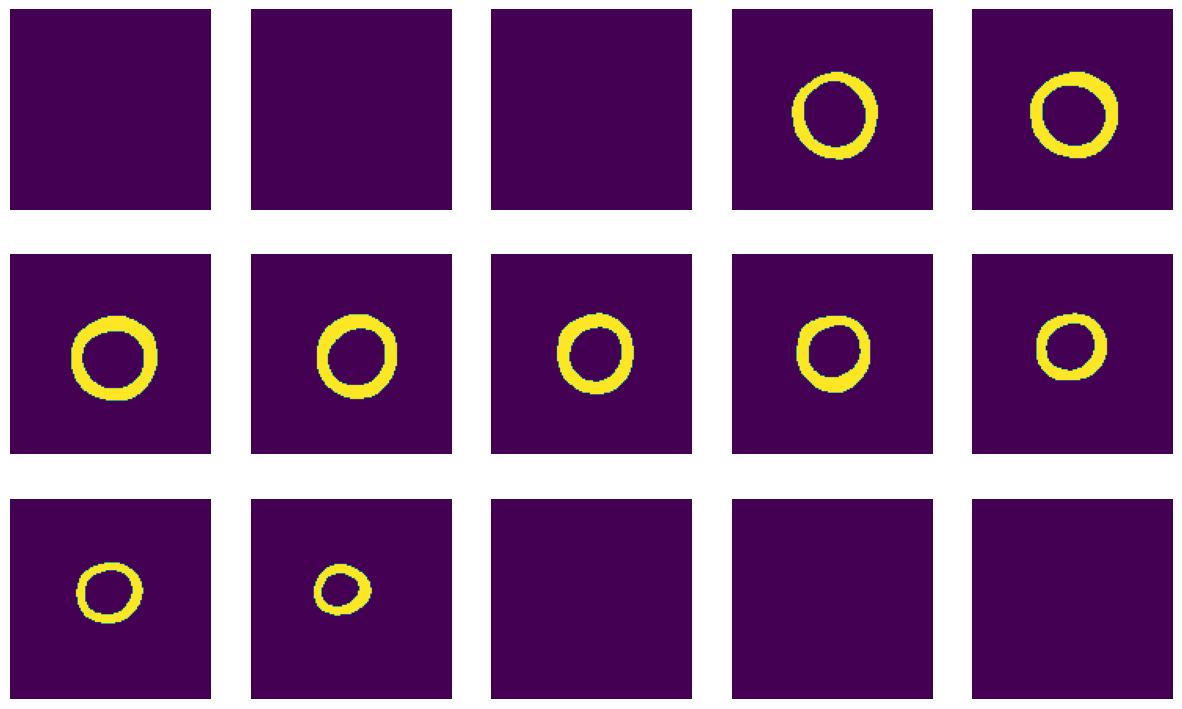

In [73]:
# plot seg_ed and seg_es
fig, ax = plt.subplots(3,5, figsize = (15,9))
for i in range(15):
    ax[i//5, i%5].imshow(pred_seg_ds[3,:,:,i])
    ax[i//5, i%5].axis('off')

# write a CNN

In [77]:
class CNNClassifier(nn.Module):
    def __init__(self, input_channels=2):
        super(CNNClassifier, self).__init__()
        self.input_channels = input_channels
        # 3D Convolutional layer to process the H, W, and Z dimensions
        self.conv1 = nn.Conv3d(in_channels=self.input_channels, out_channels=32, kernel_size=(3, 3, 3), padding=1)
        self.bn1 = nn.BatchNorm3d(32)
        self.conv2 = nn.Conv3d(in_channels=32, out_channels=64, kernel_size=(3, 3,3), padding=1)
        self.bn2 = nn.BatchNorm3d(64)
        self.conv3 = nn.Conv3d(in_channels=64, out_channels=128, kernel_size=(3, 3, 3), padding=1)
        self.bn3 = nn.BatchNorm3d(128)
        self.conv4 = nn.Conv3d(in_channels=128, out_channels=256, kernel_size=(3, 3, 3), padding=1)
        self.bn4 = nn.BatchNorm3d(256)
        
        # 2D MaxPooling layers (applied on H and W dimensions)
        self.maxpool = nn.MaxPool3d(kernel_size=(2, 2, 1))  # MaxPool on H and W only
        
        # Fully connected layers
        self.fc1 = nn.Linear(256 * 8 * 8 * 15, 512)  # Flattened size after pooling
        self.fc2 = nn.Linear(512, 2)  # Final output layer for 2 classes

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        
        # Pass through the second convolutional block
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.maxpool(x)
        
        # Pass through the third convolutional block
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.maxpool(x)
        
        # Pass through the fourth convolutional block
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.maxpool(x)
        
        # Flatten the output for the fully connected layer
        x = x.view(x.size(0), -1)
        
        # Pass through the fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

# write trainer

In [75]:
class Trainer(object):
    def __init__(
        self,
        model,
        generator_trn,
        generator_val,
        train_batch_size,
        *,
        accum_iter = 1, # gradient accumulation steps
        train_num_steps = 100, # total training epochs
        results_folder = None,
        train_lr = 1e-4,
        train_lr_decay_every = 1000, 
        save_models_every = 1,
        
        ema_update_every = 10,
        ema_decay = 0.95,
        adam_betas = (0.9, 0.99),
        max_grad_norm = 1.,):
        super().__init__()

        # accelerator
        # model
        self.model = model 
        self.accelerator = Accelerator(
            split_batches = True,
            mixed_precision = 'no'
        ) 

        # sampling and training hyperparameters
        self.batch_size = train_batch_size
        self.accum_iter = accum_iter
        self.train_num_steps = train_num_steps
        self.max_grad_norm = max_grad_norm

        # dataset and dataloader
        self.ds_trn = generator_trn
        self.dl_trn = DataLoader(self.ds_trn, batch_size = train_batch_size, shuffle = False, pin_memory = True, num_workers = 0)# cpu_count())
        self.dl_trn = self.accelerator.prepare(self.dl_trn)

        self.ds_val = generator_val
        self.dl_val = DataLoader(self.ds_val, batch_size = 1, shuffle = False, pin_memory = True, num_workers = 0)# cpu_count())
        self.dl_val = self.accelerator.prepare(self.dl_val)

        # optimizer
        self.opt = Adam(model.parameters(), lr = train_lr, betas = adam_betas)
        self.scheduler = StepLR(self.opt, step_size = 1, gamma=0.95)
        self.train_lr_decay_every = train_lr_decay_every
        self.save_model_every = save_models_every
        self.criterion = nn.CrossEntropyLoss() 

        if self.accelerator.is_main_process:
            self.ema = EMA(model, beta = ema_decay, update_every = ema_update_every)
            self.ema.to(self.device)

        self.results_folder = results_folder
    
        ff.make_folder([self.results_folder])

        # step counter state
        self.step = 0

        # prepare model, dataloader, optimizer with accelerator
        self.model, self.opt = self.accelerator.prepare(self.model, self.opt)


    @property
    def device(self):
        return self.accelerator.device

    def save(self, stepNum):
        if not self.accelerator.is_local_main_process:
            return

        data = {
            'step': self.step,
            'model': self.accelerator.get_state_dict(self.model),
            'opt': self.opt.state_dict(),
            'ema': self.ema.state_dict(),
            'decay_steps': self.scheduler.state_dict(), }
        
        torch.save(data, os.path.join(self.results_folder, 'model-' + str(stepNum) + '.pt'))

    def evaluate(self, dataloader):
        self.model.to(self.device)
        self.model.eval()  # Set model to evaluation mode
        
        total = 0
        correct = 0
        all_labels = []
        all_preds = []
        
        with torch.no_grad():
            for batch in dataloader:
                x,y = batch; x = x.to(self.device); y = y.to(self.device)
                
                # Forward pass
                outputs = self.model(x)
                
                # Get predictions
                _, predicted = torch.max(outputs, 1)
                
                # Append predictions and true labels
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(y.cpu().numpy())
                
                # Calculate correct predictions
                correct += (predicted == y).sum().item()
                total += y.size(0)

        # Calculate overall accuracy
        accuracy = correct / total
        
        # Confusion matrix
        cm = confusion_matrix(all_labels, all_preds)
        tn, fp, fn, tp = cm.ravel()

        # Calculate sensitivity and specificity
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

        # Print the results
        print(f'Accuracy: {accuracy * 100:.2f}%')
        print(f'Sensitivity (Recall): {sensitivity:.4f}')
        print(f'Specificity: {specificity:.4f}')

        return accuracy, sensitivity, specificity

    def load_model(self, trained_model_filename):

        accelerator = self.accelerator
        device = accelerator.device

        data = torch.load(trained_model_filename, map_location=device)

        model = self.accelerator.unwrap_model(self.model)
        model.load_state_dict(data['model'])

        self.step = data['step']
        self.opt.load_state_dict(data['opt'])
        if self.accelerator.is_main_process:
            self.ema.load_state_dict(data["ema"])

        self.scheduler.load_state_dict(data['decay_steps'])


    def train(self, pre_trained_model = None ,start_step = None):
        # set manual torch seed equal to 10
        torch.manual_seed(10)

        accelerator = self.accelerator
        device = accelerator.device

        training_log = []

        # load pre-trained
        if pre_trained_model is not None:
            self.load_model(pre_trained_model)
            print('model loaded from ', pre_trained_model)

        if start_step is not None:
            self.step = start_step

        with tqdm(initial = self.step, total = self.train_num_steps, disable = not accelerator.is_main_process) as pbar:
            
            while self.step < self.train_num_steps:
                print('training epoch: ', self.step + 1)
                print('learning rate: ', self.scheduler.get_last_lr()[0])

                average_loss = []
                count = 1
                # load data
                for batch in self.dl_trn:
                    if count == 1 or count % self.accum_iter == 1 or count == len(self.dl_trn) - 1 or count == len(self.dl_trn):
                        self.opt.zero_grad()
         
                    # load data
                    batch_x, batch_y = batch
                        
                    data_x = batch_x.to(device)
                    data_y = batch_y.to(device)

                    with self.accelerator.autocast():
                        output = self.model(data_x)
                        loss = self.criterion(output, data_y.squeeze(1).long())
                        
                    # accumulate the gradient, typically used when batch size is small
                    if count % self.accum_iter == 0 or count == len(self.dl_trn) - 1 or count == len(self.dl_trn):
                        self.accelerator.backward(loss)
                        accelerator.wait_for_everyone()
                        accelerator.clip_grad_norm_(self.model.parameters(), self.max_grad_norm)
                        self.opt.step()

                    count += 1
                    average_loss.append(loss.item())
                   
                average_loss = sum(average_loss) / len(average_loss)
                accelerator.wait_for_everyone()

                self.step += 1

                # save the model
                if self.step !=0 and self.step % self.save_model_every == 0:
                   self.save(self.step)
                
                if self.step !=0 and self.step % self.train_lr_decay_every == 0:
                    self.scheduler.step()
                    
                self.ema.update()

                if self.step % 10 == 0:
                    self.ds_trn.on_epoch_end(); self.ds_val.on_epoch_end()
                    acc_trn, sen_trn, spe_trn = self.evaluate(self.dl_trn)
                    acc_val, sen_val, spe_val = self.evaluate(self.dl_val)

                    # save the training log
                    training_log.append([self.step,average_loss, acc_trn, sen_trn, spe_trn, acc_val, sen_val, spe_val])
                    df = pd.DataFrame(training_log,columns = ['iteration','average_loss','acc_trn','sen_trn','spe_trn','acc_val','sen_val','spe_val'])
                    log_folder = os.path.join(os.path.dirname(self.results_folder),'log');ff.make_folder([log_folder])
                    df.to_excel(os.path.join(log_folder, 'training_log.xlsx'),index=False)
                        
                # at the end of each epoch, call on_epoch_end
                self.ds_trn.on_epoch_end()
                pbar.update(1)

        accelerator.print('training complete')

# main script

In [14]:
def split_train_val(patient_list, cross_val_batch_num, val_batch_index, save_split_file = None):
    '''X and Y first dimension is the number of cases'''
    num_of_cases_in_each_batch = int(patient_list.shape[0] / cross_val_batch_num)

    if os.path.isfile(save_split_file):
        batches = np.load(save_split_file)
    
    else:
        Y = patient_list['label_for_ML'].values
        Y_1_index = np.where(Y == 1)[0]
        Y_0_index = np.where(Y == 0)[0]
        # split these indexes into 10 groups with similar size
        Y_1_index_split = np.array_split(Y_1_index,cross_val_batch_num)

        batches = []; start = 0
        for b in range(0, cross_val_batch_num):
            current_num = Y_1_index_split[b].shape[0]
            end = start + (num_of_cases_in_each_batch - current_num)
            Y_0_batch = Y_0_index[start:end]
  
            batch = np.concatenate((Y_0_batch, Y_1_index_split[b]))
            batches.append(batch)
            start = end
        batches = np.asarray(batches); np.save(save_split_file, batches)
    val_idx = batches[val_batch_index,:]
    train_idx = np.delete(batches, val_batch_index, 0).flatten()
    return train_idx, val_idx
      

for ED+ES

In [48]:
spreadsheet_path = '/mnt/camca_NAS/HFpEF/data/HFpEF_data/Patient_list/Important_HFpEF_Patient_list_unique_patient_w_readmission_finalized.xlsx' 
patient_list = pd.read_excel(spreadsheet_path)[0:50]
manual_seg_path = '/mnt/camca_NAS/HFpEF/data/HFpEF_data/nii_manual_seg'
save_path = '/mnt/camca_NAS/Deepstrain/HFpEF_analysis/models/cnn'

train_idx, val_idx = split_train_val(patient_list, 5, 4, save_split_file = os.path.join(save_path, 'train_val_split.npy'))
print('train_idx: ', train_idx, ' val_idx: ', val_idx)
# print the labels in val
print('val labels: ', patient_list.iloc[val_idx]['label_for_ML'].values)

train_idx:  [ 1  3  5  6  7  0  2  4  9 11  8 10 13 14 15 12 17 18 20 22 16 19 21 23
 24 25 27 30 33 34 26 28 29 31 32 37 39 40 41 42]  val_idx:  [35 36 38 43 45 49 44 46 47 48]
val labels:  [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]


In [46]:
# dataset_trn = Dataset_seg_EDES(patient_list.iloc[train_idx], manual_seg_path, shuffle = True, augment = True, augment_frequency = 0.5)
# dataset_val = Dataset_seg_EDES(patient_list.iloc[val_idx], manual_seg_path, shuffle = False, augment = False)
# model = CNNClassifier(input_channels = 2)
# trainer = Trainer(model, dataset_trn, dataset_val, train_batch_size = 1, results_folder = os.path.join(save_path, 'models'), accum_iter = 1, train_num_steps = 1000, train_lr = 1e-3, train_lr_decay_every = 1000, save_models_every = 50)
# trainer.train()      

for full cycle

In [76]:
spreadsheet_path = '/mnt/camca_NAS/HFpEF/data/HFpEF_data/Patient_list/Important_HFpEF_Patient_list_unique_patient_w_readmission_finalized.xlsx' 
patient_list = pd.read_excel(spreadsheet_path)[0:50]
dl_seg_path = '/mnt/camca_NAS/SAM_for_CMR/models/sam_multiview_prompt_2box_text_HF_5shot/predicts_HFpEF'

index_list = []
for i in range(0, len(patient_list)):
    patient_id = patient_list['OurID'][i]; patient_id = ff.XX_to_ID_00XX(patient_id)
    if os.path.isdir(os.path.join(dl_seg_path, patient_id)):
        index_list.append(i)
patient_list = patient_list.iloc[index_list]

save_path = '/mnt/camca_NAS/Deepstrain/HFpEF_analysis/models/cnn_fullcycle'

train_idx, val_idx = split_train_val(patient_list, 5, 4, save_split_file = os.path.join(save_path, 'train_val_split.npy'))
print('train_idx: ', train_idx, ' val_idx: ', val_idx)
# print the labels in val
print('val labels: ', patient_list.iloc[val_idx]['label_for_ML'].values)

train_idx:  [ 1  3  5  6  0  2  4  9 11  7  8 10 13 12 17 18 20 22 14 15 16 19 21 25
 26 29 32 23 24 27 28 30 33 36 37 38]  val_idx:  [31 34 35 39 41 40 42 43 44]
val labels:  [0. 0. 0. 0. 0. 1. 1. 1. 1.]


In [78]:
dataset_trn = Dataset_seg_full(patient_list.iloc[train_idx], dl_seg_path, shuffle = True, augment = False, augment_frequency = 0.5)
dataset_val = Dataset_seg_full(patient_list.iloc[val_idx], dl_seg_path, shuffle = False, augment = False)
model = CNNClassifier(input_channels=15)
trainer = Trainer(model, dataset_trn, dataset_val, train_batch_size = 1, results_folder = os.path.join(save_path, 'models'), accum_iter = 1, train_num_steps = 1000, train_lr = 1e-3, train_lr_decay_every = 1000, save_models_every = 50)
trainer.train()      

  0%|          | 0/1000 [00:00<?, ?it/s]

training epoch:  1
learning rate:  0.001
index is:  0  now we pick patient:  ID_1172
pred_seg_files:  ['/mnt/camca_NAS/SAM_for_CMR/models/sam_multiview_prompt_2box_text_HF_5shot/predicts_HFpEF/ID_1172/epoch-81/pred_seg_0.nii.gz'
 '/mnt/camca_NAS/SAM_for_CMR/models/sam_multiview_prompt_2box_text_HF_5shot/predicts_HFpEF/ID_1172/epoch-81/pred_seg_1.nii.gz'
 '/mnt/camca_NAS/SAM_for_CMR/models/sam_multiview_prompt_2box_text_HF_5shot/predicts_HFpEF/ID_1172/epoch-81/pred_seg_2.nii.gz'
 '/mnt/camca_NAS/SAM_for_CMR/models/sam_multiview_prompt_2box_text_HF_5shot/predicts_HFpEF/ID_1172/epoch-81/pred_seg_3.nii.gz'
 '/mnt/camca_NAS/SAM_for_CMR/models/sam_multiview_prompt_2box_text_HF_5shot/predicts_HFpEF/ID_1172/epoch-81/pred_seg_4.nii.gz'
 '/mnt/camca_NAS/SAM_for_CMR/models/sam_multiview_prompt_2box_text_HF_5shot/predicts_HFpEF/ID_1172/epoch-81/pred_seg_5.nii.gz']
finally, x shape and y shape are:  torch.Size([15, 128, 128, 15]) torch.Size([1])  y value is :  tensor([1.])
index is:  1  now we pick

  0%|          | 1/1000 [00:17<4:50:47, 17.46s/it]

now run on_epoch_end function
training epoch:  2
learning rate:  0.001
index is:  0  now we pick patient:  ID_0954
pred_seg_files:  ['/mnt/camca_NAS/SAM_for_CMR/models/sam_multiview_prompt_2box_text_HF_5shot/predicts_HFpEF/ID_0954/epoch-81/pred_seg_0.nii.gz'
 '/mnt/camca_NAS/SAM_for_CMR/models/sam_multiview_prompt_2box_text_HF_5shot/predicts_HFpEF/ID_0954/epoch-81/pred_seg_1.nii.gz'
 '/mnt/camca_NAS/SAM_for_CMR/models/sam_multiview_prompt_2box_text_HF_5shot/predicts_HFpEF/ID_0954/epoch-81/pred_seg_2.nii.gz'
 '/mnt/camca_NAS/SAM_for_CMR/models/sam_multiview_prompt_2box_text_HF_5shot/predicts_HFpEF/ID_0954/epoch-81/pred_seg_3.nii.gz'
 '/mnt/camca_NAS/SAM_for_CMR/models/sam_multiview_prompt_2box_text_HF_5shot/predicts_HFpEF/ID_0954/epoch-81/pred_seg_4.nii.gz'
 '/mnt/camca_NAS/SAM_for_CMR/models/sam_multiview_prompt_2box_text_HF_5shot/predicts_HFpEF/ID_0954/epoch-81/pred_seg_5.nii.gz'
 '/mnt/camca_NAS/SAM_for_CMR/models/sam_multiview_prompt_2box_text_HF_5shot/predicts_HFpEF/ID_0954/epoch-8

  0%|          | 2/1000 [00:36<5:03:03, 18.22s/it]

now run on_epoch_end function
training epoch:  3
learning rate:  0.001
index is:  0  now we pick patient:  ID_0291
pred_seg_files:  ['/mnt/camca_NAS/SAM_for_CMR/models/sam_multiview_prompt_2box_text_HF_5shot/predicts_HFpEF/ID_0291/epoch-81/pred_seg_0.nii.gz'
 '/mnt/camca_NAS/SAM_for_CMR/models/sam_multiview_prompt_2box_text_HF_5shot/predicts_HFpEF/ID_0291/epoch-81/pred_seg_1.nii.gz'
 '/mnt/camca_NAS/SAM_for_CMR/models/sam_multiview_prompt_2box_text_HF_5shot/predicts_HFpEF/ID_0291/epoch-81/pred_seg_2.nii.gz'
 '/mnt/camca_NAS/SAM_for_CMR/models/sam_multiview_prompt_2box_text_HF_5shot/predicts_HFpEF/ID_0291/epoch-81/pred_seg_3.nii.gz'
 '/mnt/camca_NAS/SAM_for_CMR/models/sam_multiview_prompt_2box_text_HF_5shot/predicts_HFpEF/ID_0291/epoch-81/pred_seg_4.nii.gz'
 '/mnt/camca_NAS/SAM_for_CMR/models/sam_multiview_prompt_2box_text_HF_5shot/predicts_HFpEF/ID_0291/epoch-81/pred_seg_5.nii.gz'
 '/mnt/camca_NAS/SAM_for_CMR/models/sam_multiview_prompt_2box_text_HF_5shot/predicts_HFpEF/ID_0291/epoch-8

  0%|          | 3/1000 [00:53<4:55:12, 17.77s/it]

now run on_epoch_end function
training epoch:  4
learning rate:  0.001
index is:  0  now we pick patient:  ID_0291
pred_seg_files:  ['/mnt/camca_NAS/SAM_for_CMR/models/sam_multiview_prompt_2box_text_HF_5shot/predicts_HFpEF/ID_0291/epoch-81/pred_seg_0.nii.gz'
 '/mnt/camca_NAS/SAM_for_CMR/models/sam_multiview_prompt_2box_text_HF_5shot/predicts_HFpEF/ID_0291/epoch-81/pred_seg_1.nii.gz'
 '/mnt/camca_NAS/SAM_for_CMR/models/sam_multiview_prompt_2box_text_HF_5shot/predicts_HFpEF/ID_0291/epoch-81/pred_seg_2.nii.gz'
 '/mnt/camca_NAS/SAM_for_CMR/models/sam_multiview_prompt_2box_text_HF_5shot/predicts_HFpEF/ID_0291/epoch-81/pred_seg_3.nii.gz'
 '/mnt/camca_NAS/SAM_for_CMR/models/sam_multiview_prompt_2box_text_HF_5shot/predicts_HFpEF/ID_0291/epoch-81/pred_seg_4.nii.gz'
 '/mnt/camca_NAS/SAM_for_CMR/models/sam_multiview_prompt_2box_text_HF_5shot/predicts_HFpEF/ID_0291/epoch-81/pred_seg_5.nii.gz'
 '/mnt/camca_NAS/SAM_for_CMR/models/sam_multiview_prompt_2box_text_HF_5shot/predicts_HFpEF/ID_0291/epoch-8

  0%|          | 4/1000 [01:11<4:56:15, 17.85s/it]

now run on_epoch_end function
training epoch:  5
learning rate:  0.001
index is:  0  now we pick patient:  ID_0078
pred_seg_files:  ['/mnt/camca_NAS/SAM_for_CMR/models/sam_multiview_prompt_2box_text_HF_5shot/predicts_HFpEF/ID_0078/epoch-81/pred_seg_0.nii.gz'
 '/mnt/camca_NAS/SAM_for_CMR/models/sam_multiview_prompt_2box_text_HF_5shot/predicts_HFpEF/ID_0078/epoch-81/pred_seg_1.nii.gz'
 '/mnt/camca_NAS/SAM_for_CMR/models/sam_multiview_prompt_2box_text_HF_5shot/predicts_HFpEF/ID_0078/epoch-81/pred_seg_2.nii.gz'
 '/mnt/camca_NAS/SAM_for_CMR/models/sam_multiview_prompt_2box_text_HF_5shot/predicts_HFpEF/ID_0078/epoch-81/pred_seg_3.nii.gz'
 '/mnt/camca_NAS/SAM_for_CMR/models/sam_multiview_prompt_2box_text_HF_5shot/predicts_HFpEF/ID_0078/epoch-81/pred_seg_4.nii.gz'
 '/mnt/camca_NAS/SAM_for_CMR/models/sam_multiview_prompt_2box_text_HF_5shot/predicts_HFpEF/ID_0078/epoch-81/pred_seg_5.nii.gz'
 '/mnt/camca_NAS/SAM_for_CMR/models/sam_multiview_prompt_2box_text_HF_5shot/predicts_HFpEF/ID_0078/epoch-8

  0%|          | 4/1000 [01:31<6:18:20, 22.79s/it]


KeyboardInterrupt: 

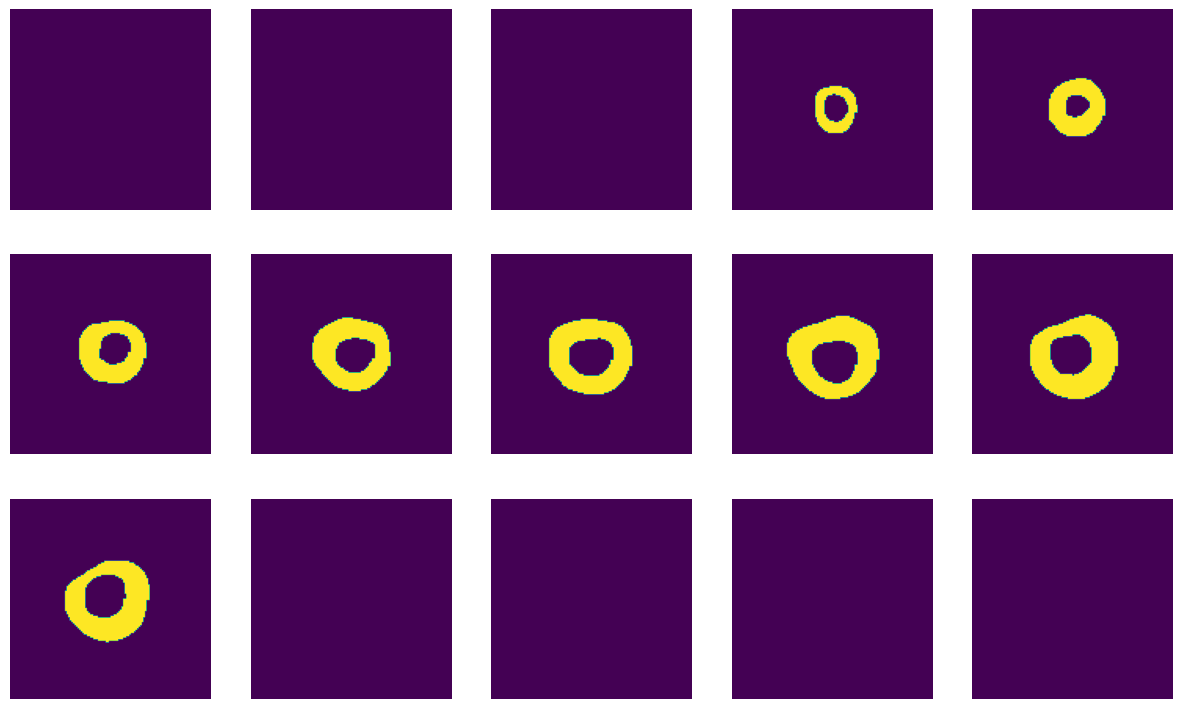

In [6]:
# plot seg_ed and seg_es
fig, ax = plt.subplots(3,5, figsize = (15,9))
for i in range(15):
    ax[i//5, i%5].imshow(seg_es[:,:,i])
    ax[i//5, i%5].axis('off')